In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import classification.utils as cls_utils
import classification.pipelines as cls_pipes
import classification.baseline_predictor as base_pred

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import utils

# 1. Data

## 1.1. Upload

In [2]:
CLS_PREP_ROOT_P = "./data_temp/2025-07-07_cls_prep"

CLS_PREP_P = os.path.join(CLS_PREP_ROOT_P, "2025-07-07_cls_prep_res_copy.csv")


SPLIT_P_NEW = os.path.join(
    CLS_PREP_ROOT_P, "2025-07-08_requests_ids_split_new.json",
)

SPLIT_P_NEW_OLD_VAL = os.path.join(
    CLS_PREP_ROOT_P, "2025-07-09_ids_new-split_old-valid_split.json",
)

In [3]:
df_cls_prep = pd.read_csv(CLS_PREP_P)
print(f'df_cls_prep: {df_cls_prep.shape}')

df_cls_prep: (44602, 16)


In [4]:
df_cls_prep.head(3)

,№ заявки,Суть обращения,Pattern_Name,Alg_Entities,Parsed_Text,NER_Entities,cards,azs,Target_Text,Target_Entities,Cls_Prep_Text,Cls_Prep_Entities,Annot_Тип,Annot_Общая_тема,Annot_Тематика,Annot_Тема_Тематика
0,77103597,\nАЗС г. Сланцы Лен.область. хочу оставить отр...,Standard,{},АЗС г. Сланцы Лен.область. хочу оставить отриц...,"[{'entity_group': 'address', 'score': np.float...","['7825682018260193', '7825686006740322']",[],АЗС г. Сланцы Лен.область. хочу оставить отриц...,"[{'beg': 4, 'end': 25, 'cat': 'address'}, {'be...",АЗС **Адрес**. хочу оставить отрицательный отз...,"[{'beg': 4, 'end': 13, 'cat': 'address'}, {'be...",Жалоба,Качество обслуживания,Работа кассира,Кач_Работа кассира
1,77103606,26 062024 я заправился на АЗС д Губкино Одинцо...,Other,{},26 062024 я заправился на АЗС д Губкино Одинцо...,"[{'entity_group': 'date', 'score': np.float32(...",[],[],26 062024 я заправился на АЗС д Губкино Одинцо...,"[{'beg': 0, 'end': 9, 'cat': 'date'}, {'beg': ...",**Дата** я заправился на АЗС **Адрес** в терми...,"[{'beg': 0, 'end': 8, 'cat': 'date'}, {'beg': ...",Заявка,Качество обслуживания,Безналичный расчет,Кач_Безналичный расчет
2,77103607,Напишите ваши пожелания или комментарии о рабо...,Standard,{},Напишите ваши пожелания или комментарии о рабо...,"[{'entity_group': 'tech_info', 'score': np.flo...",['7825682090237101'],[],Мне вчера вечером не хватало 34 литра для прод...,"[{'beg': 29, 'end': 37, 'cat': 'litr'}, {'beg'...",Мне вчера вечером не хватало **Литраж топлива*...,"[{'beg': 29, 'end': 47, 'cat': 'litr'}, {'beg'...",Консультация,Программа лояльности,Условия ПЛ/ограничения по начислениям бонусов,Про_Условия ПЛ/ограничения по начислениям бонусов


In [5]:
requests_ids_split = utils.read_json(SPLIT_P_NEW_OLD_VAL)

for _split in ['train', 'valid', 'train_leftovers']:
    print(f'{_split}: {len(requests_ids_split[_split])}')

train: 39765
valid: 4530
train_leftovers: 0


In [6]:
train_mask = df_cls_prep["№ заявки"].isin(requests_ids_split["train"])
df_dataset = df_cls_prep[train_mask]

needed_cols = [
    "№ заявки",
    "Pattern_Name", "Target_Text", "Target_Entities", # "Cls_Prep_Text",
    "Annot_Тип", "Annot_Общая_тема", "Annot_Тематика",
]
df_dataset = df_dataset[~df_dataset["Target_Text"].isna()][needed_cols]

df_dataset = df_dataset.rename(columns={"Cls_Prep_Text": "Target_Text"})

# df_dataset.shape

In [7]:
df_dataset.head(3)

,№ заявки,Pattern_Name,Target_Text,Target_Entities,Annot_Тип,Annot_Общая_тема,Annot_Тематика
0,77103597,Standard,АЗС г. Сланцы Лен.область. хочу оставить отриц...,"[{'beg': 4, 'end': 25, 'cat': 'address'}, {'be...",Жалоба,Качество обслуживания,Работа кассира
1,77103606,Other,26 062024 я заправился на АЗС д Губкино Одинцо...,"[{'beg': 0, 'end': 9, 'cat': 'date'}, {'beg': ...",Заявка,Качество обслуживания,Безналичный расчет
2,77103607,Standard,Мне вчера вечером не хватало 34 литра для прод...,"[{'beg': 29, 'end': 37, 'cat': 'litr'}, {'beg'...",Консультация,Программа лояльности,Условия ПЛ/ограничения по начислениям бонусов


## 1.2. Dataset Prep

In [16]:
pipe_name = "train_no-text-proc_ents-drop"
train_pipe_container = cls_pipes.get_pipe(
    steps=cls_pipes.PIPES[pipe_name],
    descr=pipe_name
)

In [17]:
df_dataset_prep = train_pipe_container.pipe.fit_transform(df_dataset)

Drop Empty length change: 39765 -> 39765
Duplicates deletion length change: 39765 -> 36835
Target prunning length change: 36835 -> 36831


In [18]:
df_dataset_prep.shape

(36831, 7)

In [8]:
DS_ROOT_P = './data_temp/2025-07-09_classification'
os.makedirs(DS_ROOT_P, exist_ok=True)

DS_PREP_P = os.path.join(DS_ROOT_P, 'df_dataset_prep.csv')

In [40]:
# df_dataset_prep.to_csv(DS_PREP_P, index=False)

In [9]:
df_dataset_prep = pd.read_csv(DS_PREP_P)
df_dataset_prep.shape

(35511, 6)

In [12]:
# df_dataset_prep.head(10)

In [11]:
_t_idx = 1

processed_text = df_dataset_prep["Target_Text"].iloc[_t_idx]
processed_id = df_dataset_prep["№ заявки"].iloc[_t_idx]

id_mask = df_dataset["№ заявки"] == processed_id
src_text = df_dataset[id_mask].iloc[0]["Target_Text"]

print("--- Source")
print(src_text)

print("--- Processed")
print(processed_text)

--- Source
 не могу выбрать карту для участия в акции кэшбэк 7% Нажимаю на карту а приложение зависает!
--- Processed
выбрать карту участия акции к% нажимаю карту приложение зависает


In [43]:
coverage_type = (
    df_dataset_prep
    .groupby('Annot_Тип')
    .size()
    .reset_index(name='Обращения')
    .sort_values('Обращения', ascending=False)
)
_total_type = pd.DataFrame({
    'Annot_Тип': ['Total'],
    'Обращения': [coverage_type['Обращения'].sum()],
})
coverage_type = pd.concat([coverage_type, _total_type])
coverage_type

,Annot_Тип,Обращения
3,Заявка,16781
4,Консультация,10321
1,Дополнение к тикету,8837
2,Жалоба,707
5,Пожелание,131
0,Благодарность,54
0,Total,36831


In [44]:
coverage_topic = (
    df_dataset_prep
    .groupby(['Annot_Общая_тема', 'Annot_Тематика'])
    .size()
    .reset_index(name='Обращения')
    .groupby(['Annot_Общая_тема'])
    .agg({'Annot_Тематика': 'count', 'Обращения': 'sum'})
    .sort_values(['Обращения'], ascending=False)
    .reset_index()
    .rename(columns={'Annot_Тематика': 'Тематики'})
)

_total_topic = pd.DataFrame({
    'Annot_Общая_тема': ['Total'],
    'Тематики': [coverage_topic['Тематики'].sum()],
    'Обращения': [coverage_topic['Обращения'].sum()],
})
coverage_topic = pd.concat([coverage_topic, _total_topic])
coverage_topic

,Annot_Общая_тема,Тематики,Обращения
0,Программа лояльности,19,20532
1,Мобильное приложение,7,3180
2,Акции,9,2783
3,Качество обслуживания,11,2767
4,Онлайн Оплата,6,2592
5,ЧаВо,6,1468
6,Нецелевой звонок,7,1133
7,Использование ААЗС,7,1052
8,Топливо,6,1051
9,СТиУ,4,273


# 2. Models

In [45]:
FEATURE_COLUMN = 'Target_Text'

In [46]:
MODELS = [
    # 'DeepPavlov/rubert-base-cased-sentence',
    # 'BAAI/bge-m3',
    # 'ai-forever/sbert_large_mt_nlu_ru',
    'deepvk/deberta-v1-base',
    # 'symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli',
]

In [47]:
embedders = cls_utils.load_models(MODELS)

deepvk/deberta-v1-base


No sentence-transformers model found with name deepvk/deberta-v1-base. Creating a new one with mean pooling.


## 2.1. Text Vectorizing

In [48]:
VECTORIZED_DS_ROOT_P = './data_temp/2025-07-09_classification/vectorized-text_no-txt-proc_ents-drop'

os.makedirs(VECTORIZED_DS_ROOT_P, exist_ok=True)

In [49]:
def vectorize_text(
    texts: list[str],
    embedder,
    batch_size: int,
    device: str,
    save_path: str,
):
    encoded = embedder.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        device=device,
    )
    print(f'Encoded size: {encoded.shape}')
    np.save(save_path, encoded)
    print(f'Saved vectors as {save_path}')

In [50]:
embedder_name = 'deepvk/deberta-v1-base'
embedder = embedders[embedder_name]

backbone_name = f'{embedder_name.replace("/", "_")}.npy'
vectors_p = os.path.join(VECTORIZED_DS_ROOT_P, backbone_name)

In [ ]:
vectorize_text(
    texts=df_dataset_prep[FEATURE_COLUMN],
    embedder=embedder,
    batch_size=16,
    device='cuda:0',
    save_path=vectors_p,
)

In [52]:
encoded_loaded = np.load(vectors_p)
encoded_loaded.shape

(36831, 768)

In [53]:
# del embedder
# del embedders
torch.cuda.empty_cache()

# 3. Training

In [54]:
RANDOM_SEEED = 42
TEST_SIZE = 0.2

MAX_ITER = 1_000


MODELS = [
    # 'DeepPavlov/rubert-base-cased-sentence',
    # 'BAAI/bge-m3',
    # 'ai-forever/sbert_large_mt_nlu_ru',
    'deepvk/deberta-v1-base',
    # 'symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli',
]

VECTORS_PATHS = {
    emb_name: os.path.join(VECTORIZED_DS_ROOT_P, f'{emb_name.replace("/", "_")}.npy')
    for emb_name in MODELS
}

## 3.1. Mesage Type
Тип обращения

In [55]:
df_dataset_prep.shape

(36831, 7)

In [56]:
add_type_mask = df_dataset_prep['Annot_Тип'] == 'Дополнение к тикету'

In [57]:
type_label_encoder = LabelEncoder()
y_type_labels = type_label_encoder.fit_transform(df_dataset_prep['Annot_Тип'][~add_type_mask])

y_type_labels.shape

(27994,)

In [58]:
samples_idxs = np.arange(y_type_labels.shape[0])

type_X_train_idxs, type_X_test_idxs, type_y_train, type_y_test = train_test_split(
    samples_idxs,
    y_type_labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEEED,
    stratify=y_type_labels,
)

print(f'Total: {samples_idxs.shape[0]}')
print(f'Train: {type_X_train_idxs.shape[0]}')
print(f'Test: {type_X_test_idxs.shape[0]}')

Total: 27994
Train: 22395
Test: 5599


In [59]:
type_results = {}

for embed_name, vects_p in VECTORS_PATHS.items():
    print(f'Embedder: {embed_name}')
    
    X = np.load(vects_p)[~add_type_mask]
    print(f'  Uploaded vectors shape: {X.shape}')

    print(f'  Preparing dataset..')
    # train
    type_X_train = X[type_X_train_idxs]
    type_scaler = StandardScaler()
    type_X_train_scaled = type_scaler.fit_transform(type_X_train)
    # test
    type_X_test = X[type_X_test_idxs]
    type_X_test_scaled = type_scaler.transform(type_X_test)

    print(f'  Fitting model..')
    type_model = LogisticRegression(random_state=RANDOM_SEEED, max_iter=MAX_ITER)
    type_model.fit(type_X_train_scaled, type_y_train)

    print(f'  Testing model..')
    type_y_pred = type_model.predict(type_X_test_scaled)

    print("  Classification Report:")
    type_cls_report = cls_utils.classification_report(
        type_y_test,
        type_y_pred,
        target_names=type_label_encoder.classes_,
    )
    print(type_cls_report)
    f1_beta = cls_utils.calculate_beta_f1(type_y_test, type_y_pred)
    type_results[embed_name] = {
        'f1_beta': f1_beta,
        'predictions': type_y_pred,
        'scaler': type_scaler,
        'model': type_model,
    }
    print(f"  Mean weighted F1 beta: {round(f1_beta, 3)}")

Embedder: deepvk/deberta-v1-base
  Uploaded vectors shape: (27994, 768)
  Preparing dataset..
  Fitting model..
  Testing model..
  Classification Report:
               precision    recall  f1-score   support

Благодарность       1.00      0.27      0.43        11
       Жалоба       0.40      0.43      0.41       142
       Заявка       0.75      0.79      0.77      3356
 Консультация       0.67      0.61      0.64      2064
    Пожелание       0.05      0.04      0.04        26

     accuracy                           0.71      5599
    macro avg       0.57      0.43      0.46      5599
 weighted avg       0.71      0.71      0.71      5599

  Mean weighted F1 beta: 0.709


In [60]:
for embed_name, res in type_results.items():
    print(f'{embed_name}: {round(res["f1_beta"], 3)}')

deepvk/deberta-v1-base: 0.709


<Figure size 1000x800 with 0 Axes>

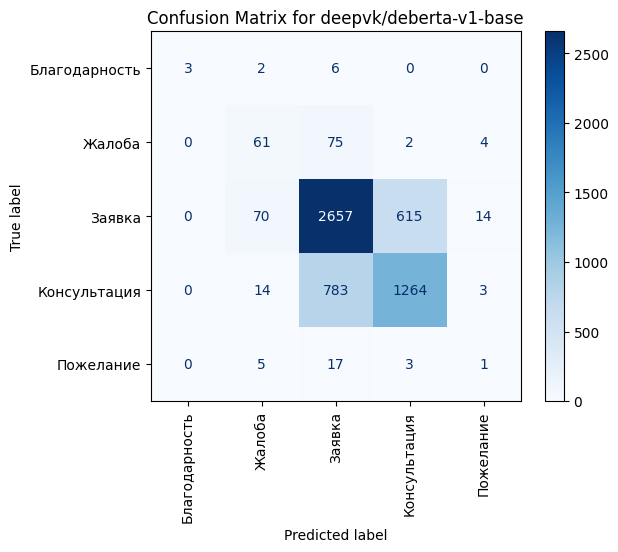

In [61]:
_t_embed_name = 'deepvk/deberta-v1-base'

cls_utils.plot_confusion_matrix(
    type_y_test,
    type_results[_t_embed_name]['predictions'],
    type_label_encoder.classes_,
    title=f'Confusion Matrix for {_t_embed_name}',
);

Save Model

In [62]:
MODELS_ROOT_P = './data_temp/2025-07-09_classification/models_2025-07-10_no-txt-proc_ents-drop'
os.makedirs(MODELS_ROOT_P, exist_ok=True)

TYPE_MODEL_P = os.path.join(MODELS_ROOT_P, 'type_model_log-reg.joblib')
TYPE_SCALER_P = os.path.join(MODELS_ROOT_P, 'type_model_scaler.joblib')
TYPE_LABEL_ENC_P = os.path.join(MODELS_ROOT_P, 'type_prep_labeler.joblib')

In [63]:
joblib.dump(type_results[_t_embed_name]['model'], TYPE_MODEL_P)
joblib.dump(type_results[_t_embed_name]['scaler'], TYPE_SCALER_P)
joblib.dump(type_label_encoder, TYPE_LABEL_ENC_P)

['./data_temp/2025-07-09_classification/models_2025-07-10_no-txt-proc_ents-drop/type_prep_labeler.joblib']

In [64]:
_t_type_model = joblib.load(TYPE_MODEL_P)
print(_t_type_model)

_t_type_scaler = joblib.load(TYPE_SCALER_P)
print(_t_type_scaler)

_t_type_labeler = joblib.load(TYPE_LABEL_ENC_P)
print(_t_type_labeler)

LogisticRegression(max_iter=1000, random_state=42)
StandardScaler()
LabelEncoder()


In [65]:
_t_embed_name = 'deepvk/deberta-v1-base'
_t_features = np.load(VECTORS_PATHS[_t_embed_name])[~add_type_mask]

# test
_t_features_test = _t_features[type_X_test_idxs]
_t_features_test_scaled = _t_type_scaler.transform(_t_features_test)
# metrics
_t_pred = _t_type_model.predict(_t_features_test_scaled)
_t_f1_beta = cls_utils.calculate_beta_f1(type_y_test, _t_pred)
print(f"Mean weighted F1 beta: {round(_t_f1_beta, 3)}")

Mean weighted F1 beta: 0.709


## 3.2. General Topic
Общая тема

In [66]:
gentopic_label_encoder = LabelEncoder()
y_gentopic_labels = gentopic_label_encoder.fit_transform(df_dataset_prep['Annot_Общая_тема'])

y_gentopic_labels.shape

(36831,)

In [67]:
gentopic_samples_idxs = np.arange(y_gentopic_labels.shape[0])

gentopic_X_train_idxs, gentopic_X_test_idxs, gentopic_y_train, gentopic_y_test = train_test_split(
    gentopic_samples_idxs,
    y_gentopic_labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEEED,
    stratify=y_gentopic_labels,
)

print(f'Total: {gentopic_samples_idxs.shape[0]}')
print(f'Train: {gentopic_X_train_idxs.shape[0]}')
print(f'Test: {gentopic_X_test_idxs.shape[0]}')

Total: 36831
Train: 29464
Test: 7367


In [68]:
gentopic_results = {}

for embed_name, vects_p in VECTORS_PATHS.items():
    print(f'Embedder: {embed_name}')
    
    X = np.load(vects_p)
    print(f'  Uploaded vectors shape: {X.shape}')

    print(f'  Preparing dataset..')
    # train
    gentopic_X_train = X[gentopic_X_train_idxs]
    gentopic_scaler = StandardScaler()
    gentopic_X_train_scaled = gentopic_scaler.fit_transform(gentopic_X_train)
    # test
    gentopic_X_test = X[gentopic_X_test_idxs]
    gentopic_X_test_scaled = gentopic_scaler.transform(gentopic_X_test)

    print(f'  Fitting model..')
    gentopic_model = LogisticRegression(random_state=RANDOM_SEEED, max_iter=MAX_ITER)
    gentopic_model.fit(gentopic_X_train_scaled, gentopic_y_train)

    print(f'  Testing model..')
    gentopic_y_pred = gentopic_model.predict(gentopic_X_test_scaled)

    print("  Classification Report:")
    gentopic_cls_report = cls_utils.classification_report(
        gentopic_y_test,
        gentopic_y_pred,
        target_names=gentopic_label_encoder.classes_,
    )
    print(gentopic_cls_report)
    f1_beta = cls_utils.calculate_beta_f1(gentopic_y_test, gentopic_y_pred)
    gentopic_results[embed_name] = {
        'f1_beta': f1_beta,
        'predictions': gentopic_y_pred,
        'scaler': gentopic_scaler,
        'model': gentopic_model,
    }
    print(f"  Mean weighted F1 beta: {round(f1_beta, 3)}")

Embedder: deepvk/deberta-v1-base
  Uploaded vectors shape: (36831, 768)
  Preparing dataset..
  Fitting model..
  Testing model..
  Classification Report:
                       precision    recall  f1-score   support

                Акции       0.81      0.78      0.79       557
   Использование ААЗС       0.59      0.58      0.59       210
Качество обслуживания       0.66      0.65      0.65       553
 Мобильное приложение       0.65      0.52      0.57       636
     Нецелевой звонок       0.47      0.33      0.39       227
        Онлайн Оплата       0.69      0.67      0.68       518
 Программа лояльности       0.87      0.92      0.89      4107
                 СТиУ       0.68      0.55      0.61        55
              Топливо       0.63      0.70      0.67       210
                 ЧаВо       0.65      0.67      0.66       294

             accuracy                           0.79      7367
            macro avg       0.67      0.64      0.65      7367
         weighted avg   

In [69]:
for embed_name, res in gentopic_results.items():
    print(f'{embed_name}: {round(res["f1_beta"], 3)}')

deepvk/deberta-v1-base: 0.782


<Figure size 1000x800 with 0 Axes>

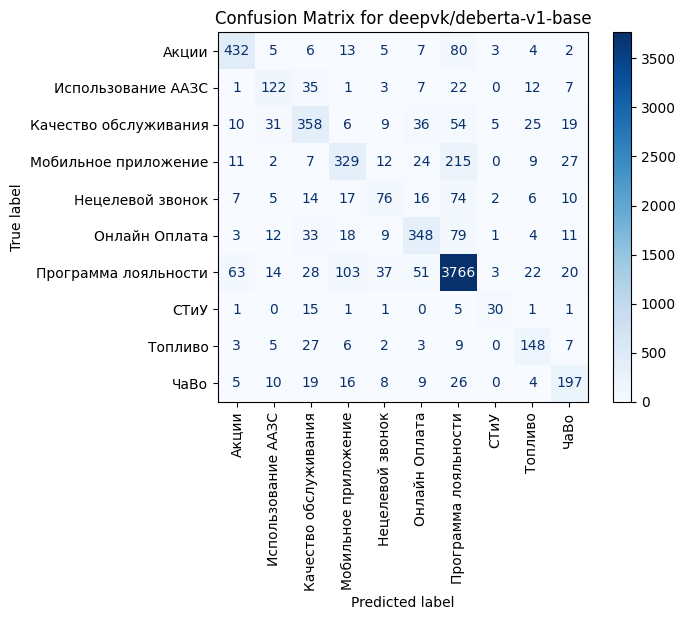

In [70]:
_t_embed_name = 'deepvk/deberta-v1-base'

cls_utils.plot_confusion_matrix(
    gentopic_y_test,
    gentopic_results[_t_embed_name]['predictions'],
    gentopic_label_encoder.classes_,
    title=f'Confusion Matrix for {_t_embed_name}',
);

Save Model

In [71]:
# MODELS_ROOT_P = './data_temp/2025-04-18_classification/models'
os.makedirs(MODELS_ROOT_P, exist_ok=True)

GENTOPIC_MODEL_P = os.path.join(MODELS_ROOT_P, 'gentopic_model_log-reg.joblib')
GENTOPIC_SCALER_P = os.path.join(MODELS_ROOT_P, 'gentopic_model_scaler.joblib')
GENTOPIC_LABEL_ENC_P = os.path.join(MODELS_ROOT_P, 'gentopic_prep_labeler.joblib')

In [72]:
joblib.dump(gentopic_results[_t_embed_name]['model'], GENTOPIC_MODEL_P)
joblib.dump(gentopic_results[_t_embed_name]['scaler'], GENTOPIC_SCALER_P)
joblib.dump(gentopic_label_encoder, GENTOPIC_LABEL_ENC_P)

['./data_temp/2025-07-09_classification/models_2025-07-10_no-txt-proc_ents-drop/gentopic_prep_labeler.joblib']

In [73]:
_t_gentopic_model = joblib.load(GENTOPIC_MODEL_P)
print(_t_gentopic_model)

_t_gentopic_scaler = joblib.load(GENTOPIC_SCALER_P)
print(_t_gentopic_scaler)

_t_gentopic_labeler = joblib.load(GENTOPIC_LABEL_ENC_P)
print(_t_gentopic_labeler)

LogisticRegression(max_iter=1000, random_state=42)
StandardScaler()
LabelEncoder()


In [74]:
_t_features = np.load(VECTORS_PATHS[_t_embed_name])

# test
_t_features_test = _t_features[gentopic_X_test_idxs]
_t_features_test_scaled = _t_gentopic_scaler.transform(_t_features_test)
# metrics
_t_pred = _t_gentopic_model.predict(_t_features_test_scaled)
_t_f1_beta = cls_utils.calculate_beta_f1(gentopic_y_test, _t_pred)
print(f"Mean weighted F1 beta: {round(_t_f1_beta, 3)}")

Mean weighted F1 beta: 0.782


## 3.3. Sub Topics
Тематика

In [75]:
df_dataset_prep_subtopic = pd.merge(
    df_dataset_prep,
    df_cls_prep[["№ заявки", "Annot_Тема_Тематика"]],
    on="№ заявки",
    how="inner",
)
df_dataset_prep_subtopic.shape

(36831, 8)

In [76]:
valid_subtopics = df_cls_prep[
    df_cls_prep["№ заявки"].isin(requests_ids_split["valid"])
]["Annot_Тема_Тематика"].unique()
valid_subtopics.shape

df_vmask = df_dataset_prep_subtopic[
    "Annot_Тема_Тематика"
].isin(valid_subtopics)

df_vmask.sum()

np.int64(35960)

In [77]:
embed_name = 'deepvk/deberta-v1-base'
vects_p = VECTORS_PATHS[embed_name]

X = np.load(vects_p)[df_vmask]
print(f'Uploaded vectors shape: {X.shape}')

sub_results = {}
for gen_topic in df_dataset_prep[df_vmask]['Annot_Общая_тема'].unique():
    print(f'General Topic: {gen_topic}')
    
    print(f'  Preparing dataset..')
    crnt_sub_mask = df_dataset_prep[df_vmask]['Annot_Общая_тема'] == gen_topic
    # labels
    sub_label_encoder = LabelEncoder()
    y_sub_labels = sub_label_encoder.fit_transform(df_dataset_prep[df_vmask]['Annot_Тематика'][crnt_sub_mask])
    # split
    sub_samples_idxs = np.arange(y_sub_labels.shape[0])
    sub_X_train_idxs, sub_X_test_idxs, sub_y_train, sub_y_test = train_test_split(
        sub_samples_idxs,
        y_sub_labels,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEEED,
        stratify=y_sub_labels,
    )
    # train
    sub_X_train = X[crnt_sub_mask][sub_X_train_idxs]
    sub_scaler = StandardScaler()
    sub_X_train_scaled = sub_scaler.fit_transform(sub_X_train)
    # test
    sub_X_test = X[crnt_sub_mask][sub_X_test_idxs]
    sub_X_test_scaled = sub_scaler.transform(sub_X_test)
    print(f'    train: {sub_X_train.shape[0]}')
    print(f'    test: {sub_X_test.shape[0]}')

    print(f'  Fitting model..')
    sub_model = LogisticRegression(random_state=RANDOM_SEEED, max_iter=MAX_ITER)
    sub_model.fit(sub_X_train_scaled, sub_y_train)

    print(f'  Testing model..')
    sub_y_pred = sub_model.predict(sub_X_test_scaled)

    '''print("  Classification Report:")
    sub_cls_report = cls_utils.classification_report(
        sub_y_test,
        sub_y_pred,
        target_names=sub_label_encoder.classes_,
    )
    print(sub_cls_report)'''
    
    f1_beta = cls_utils.calculate_beta_f1(sub_y_test, sub_y_pred)
    sub_results[gen_topic] = {
        'f1_beta': f1_beta,
        'predictions': sub_y_pred,
        'scaler': sub_scaler,
        'model': sub_model,
        'label_encoder': sub_label_encoder,
        'split': {
            'X_train_idxs': sub_X_train_idxs,
            'X_test_idxs': sub_X_test_idxs,
            'y_train': sub_y_train,
            'y_test': sub_y_test,
        }
        
    }
    print(f"  Mean weighted F1 beta: {round(f1_beta, 3)}")

Uploaded vectors shape: (35960, 768)
General Topic: Акции
  Preparing dataset..
    train: 2173
    test: 544
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.831
General Topic: Использование ААЗС
  Preparing dataset..
    train: 792
    test: 199
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.662
General Topic: Качество обслуживания
  Preparing dataset..
    train: 2105
    test: 527
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.742
General Topic: Мобильное приложение
  Preparing dataset..
    train: 2509
    test: 628
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.735
General Topic: Нецелевой звонок
  Preparing dataset..
    train: 714
    test: 179
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.716
General Topic: Онлайн Оплата
  Preparing dataset..
    train: 2044
    test: 512
  Fitting model..
  Testing model..
  Mean weighted F1 beta: 0.803
General Topic: Программа лояльности
  Preparing dataset..
    

In [78]:
for gen_topic, res in sub_results.items():
    print(f'{gen_topic}: {round(res["f1_beta"], 3)}')

sub_f1_mean = np.mean([res["f1_beta"] for res in sub_results.values()]).item()
print(f'\nsub f1_beta mean: {round(sub_f1_mean, 3)}')

Акции: 0.831
Использование ААЗС: 0.662
Качество обслуживания: 0.742
Мобильное приложение: 0.735
Нецелевой звонок: 0.716
Онлайн Оплата: 0.803
Программа лояльности: 0.563
СТиУ: 0.897
Топливо: 0.805
ЧаВо: 0.937

sub f1_beta mean: 0.769


In [40]:
'''for gen_topic, res in sub_results.items():
    cls_utils.plot_confusion_matrix(
        res['split']['y_test'],
        res['predictions'],
        res['label_encoder'].classes_,
        title=f'Confusion Matrix for {gen_topic}',
    )''';

Save Models

In [79]:
gen_topic_map = {}
for gen_topic, res in sub_results.items():
    gen_topic_map[gen_topic] = len(gen_topic_map)

gen_topic_map

{'Акции': 0,
 'Использование ААЗС': 1,
 'Качество обслуживания': 2,
 'Мобильное приложение': 3,
 'Нецелевой звонок': 4,
 'Онлайн Оплата': 5,
 'Программа лояльности': 6,
 'СТиУ': 7,
 'Топливо': 8,
 'ЧаВо': 9}

In [81]:
# SUB_MODELS_ROOT_P = './data_temp/2025-04-18_classification/models/subtopics'

SUB_MODELS_ROOT_P = './data_temp/2025-07-09_classification/models_2025-07-10_no-txt-proc_ents-drop/subtopics'
os.makedirs(SUB_MODELS_ROOT_P, exist_ok=True)

SUB_MODELS_P = {}

for gen_topic in sub_results.keys():
    idx = len(SUB_MODELS_P)
    SUB_MODELS_P[gen_topic] = {
        'model': os.path.join(SUB_MODELS_ROOT_P, f'sub-{idx}_model_log-reg.joblib'),
        'scaler': os.path.join(SUB_MODELS_ROOT_P, f'sub-{idx}_model_scaler.joblib'),
        'labeler': os.path.join(SUB_MODELS_ROOT_P, f'sub-{idx}_prep_labeler.joblib')
    }

In [82]:
for gen_topic, res in sub_results.items():
    joblib.dump(res['model'], SUB_MODELS_P[gen_topic]['model'])
    joblib.dump(res['scaler'], SUB_MODELS_P[gen_topic]['scaler'])
    joblib.dump(res['label_encoder'], SUB_MODELS_P[gen_topic]['labeler'])

In [83]:
_t_sub_models = {}
for gen_topic, paths in SUB_MODELS_P.items():
    _t_sub_models[gen_topic] = {
        'model': joblib.load(paths['model']),
        'scaler': joblib.load(paths['scaler']),
        'labeler': joblib.load(paths['labeler']),
    }

In [84]:
embed_name = 'deepvk/deberta-v1-base'
vects_p = VECTORS_PATHS[embed_name]
_t_features = np.load(vects_p)[df_vmask]


_t_f1_vals = []
for gen_topic, models in _t_sub_models.items():
    crnt_sub_mask = df_dataset_prep[df_vmask]['Annot_Общая_тема'] == gen_topic
    # test
    _t_X_test_idxs = sub_results[gen_topic]['split']['X_test_idxs']
    _t_features_test = _t_features[crnt_sub_mask][_t_X_test_idxs]
    _t_features_test_scaled = models['scaler'].transform(_t_features_test)
    # metrics
    _t_pred = models['model'].predict(_t_features_test_scaled)
    _t_y_test = sub_results[gen_topic]['split']['y_test']
    _t_f1_beta = cls_utils.calculate_beta_f1(_t_y_test, _t_pred)
    print(f"{gen_topic}: {round(_t_f1_beta, 3)}")
    _t_f1_vals.append(_t_f1_beta)

_t_f1_mean = round(sum(_t_f1_vals) / len(_t_f1_vals), 3)
print(f'\nsub f1_beta mean: {round(_t_f1_mean, 3)}')

Акции: 0.831
Использование ААЗС: 0.662
Качество обслуживания: 0.742
Мобильное приложение: 0.735
Нецелевой звонок: 0.716
Онлайн Оплата: 0.803
Программа лояльности: 0.563
СТиУ: 0.897
Топливо: 0.805
ЧаВо: 0.937

sub f1_beta mean: 0.769


# 4. (Type, Topic, Subtopic) Predictor

In [45]:
MODELS_ROOT_P = './data_temp/2025-04-18_classification/models'

In [48]:
predictor = base_pred.TypeTopicSubtopic(MODELS_ROOT_P, gen_topic_map)

In [49]:
type_X = np.load(VECTORS_PATHS['BAAI/bge-m3'])
print(f'type X: {type_X.shape}')

topic_X = np.load(VECTORS_PATHS['BAAI/bge-m3'])
print(f'topic X: {topic_X.shape}')

type X: (16621, 1024)
topic X: (16621, 1024)


In [50]:
_sample_idx = 100
_t_inp = base_pred.PredictorInput(
    type_vect=type_X[~add_type_mask][type_X_test_idxs][_sample_idx],
    topic_vect=topic_X[gentopic_X_test_idxs][_sample_idx],
    subtopic_vect=topic_X[gentopic_X_test_idxs][_sample_idx],
)
_t_res = predictor.infer(_t_inp)
_t_res_names = predictor.postprocess(_t_res)
_t_res, _t_res_names

(array([2, 2, 4]), ['Заявка', 'Качество обслуживания', 'Режим работы АЗС'])

In [51]:
_t_batch_res = []
_t_batch_names_res = []
for _sample_idx in range(100, 110):
    _t_batch = base_pred.PredictorInput(
        type_vect=type_X[~add_type_mask][type_X_test_idxs][_sample_idx],
        topic_vect=topic_X[gentopic_X_test_idxs][_sample_idx],
        subtopic_vect=topic_X[gentopic_X_test_idxs][_sample_idx],
    )
    _t_res = predictor.infer(_t_batch)
    _t_batch_res.append(_t_res)
    _t_res_names = predictor.postprocess(_t_res)
    _t_batch_names_res.append(_t_res_names)

np.vstack(_t_batch_res)

array([[ 2,  2,  4],
       [ 2,  5,  3],
       [ 2,  6, 14],
       [ 3,  6,  2],
       [ 2,  6,  8],
       [ 1,  6,  4],
       [ 2,  1,  1],
       [ 3,  1,  3],
       [ 2,  6, 13],
       [ 3,  4,  1]])

In [52]:
_t_batch_names_res

[['Заявка', 'Качество обслуживания', 'Режим работы АЗС'],
 ['Заявка', 'Онлайн Оплата', 'Способ оплаты'],
 ['Заявка', 'Программа лояльности', 'Условия ПЛ'],
 ['Консультация', 'Программа лояльности', 'Виртуальная карта лояльности'],
 ['Заявка', 'Программа лояльности', 'Не начислены бонусы ВКЛ (NFC и QR)'],
 ['Жалоба', 'Программа лояльности', 'Доначисление бонусов (пластик)'],
 ['Заявка', 'Использование ААЗС', 'Не работает купюроприемник'],
 ['Консультация', 'Использование ААЗС', 'Отсутствие пролива'],
 ['Заявка', 'Программа лояльности', 'Управление бонусной картой'],
 ['Консультация', 'Нецелевой звонок', 'Пустой e-mail']]